# Create and Train Model

In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import librosa

import config
from data_loading import load_data_from_dir


# 1 Two Models to Train Each Batch : Wav Features

## 1.1 Load Split Data

### 1.1.1 Load Training Data

In [2]:
train_wav_dirs = [config.TRAIN_WAV_MFCCS, config.TRAIN_AUG_WAV_MFCCS]

X_train_wav = []
y_train_wav = []

scaler = StandardScaler()

for train_dir in train_wav_dirs:
    for file_name in os.listdir(train_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(train_dir, file_name)
            mfccs = np.load(file_path)
            # scale data
            mfccs = scaler.fit_transform(mfccs)

            X_train_wav.append(mfccs)
            label = file_name.split('.npy')[0]
            y_train_wav.append(label)

X_train_wav = np.array(X_train_wav)
y_train_wav = np.array(y_train_wav)


In [3]:
X_train_wav.shape, y_train_wav.shape

((1716, 40, 775), (1716,))

### 1.1.2 Load Test Data

In [4]:
test_dirs = [config.TEST_WAV_MFCCS]

X_test_wav = []
y_test_wav = []

for test_dir in test_dirs:
    for file_name in os.listdir(test_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(test_dir, file_name)
            mfccs = np.load(file_path)

            mfccs = scaler.fit_transform(mfccs)

            X_test_wav.append(mfccs)
            label = file_name.split('.npy')[0]
            y_test_wav.append(label)

X_test_wav = np.array(X_test_wav)
y_test_wav = np.array(y_test_wav)


In [5]:
X_test_wav.shape, y_test_wav.shape

((216, 40, 775), (216,))

### 1.1.3 Load Validation Data

In [6]:
val_dirs = [config.VAL_WAV_MFCCS]

X_val_wav = []
y_val_wav = []

for val_dir in val_dirs:
    for file_name in os.listdir(val_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(val_dir, file_name)
            mfccs = np.load(file_path)

            mfccs = scaler.fit_transform(mfccs)
            
            X_val_wav.append(mfccs)
            label = file_name.split('.npy')[0]
            y_val_wav.append(label)

X_val_wav = np.array(X_val_wav)
y_val_wav = np.array(y_val_wav)


In [7]:
X_val_wav.shape, y_val_wav.shape

((184, 40, 775), (184,))

Get number of classes from filename for model

In [8]:
filenames, labels = load_data_from_dir(config.WAV_DIR_PATH)

emotion_labels = [filename.split('-')[2] for filename in filenames] # based on filename identifiers https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

num_classes = len(np.unique(emotion_labels))

print("Number of classes (emotions):", num_classes)

Number of classes (emotions): 8


## 1.3 Define Model

### 1.3.1 Reshape the data to fit the model

In [9]:
X_train_wav_reshaped = X_train_wav.reshape(X_train_wav.shape[0], X_train_wav.shape[1], X_train_wav.shape[2], 1)
X_test_wav_reshaped = X_test_wav.reshape(X_test_wav.shape[0], X_test_wav.shape[1], X_test_wav.shape[2], 1)
X_val_wav_reshaped = X_val_wav.reshape(X_val_wav.shape[0], X_val_wav.shape[1], X_val_wav.shape[2], 1)

In [10]:
X_train_wav_reshaped.shape

(1716, 40, 775, 1)

### 1.3.2 Model Definition

In [11]:
wav_model = models.Sequential([
    layers.Input(shape=X_train_wav_reshaped.shape[1:]),
    layers.Conv2D(32, (5, 5), activation='relu', name='ConvLayer_1'),
    layers.MaxPooling2D((2, 2), name='Max_Pool_1'),

    layers.Conv2D(64, (5, 5), activation='relu', name='ConvLayer_2'),
    layers.MaxPooling2D((2, 2), name='Max_Pool_2'),

    layers.Conv2D(128, (5, 5), activation='relu', name='ConvLayer_3'),
    layers.MaxPooling2D((2, 2), name='Max_Pool_3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


### 1.3.1 Show Summary of Model

In [12]:
wav_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ConvLayer_1 (Conv2D)            │ (None, 36, 771, 64)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pool_1 (MaxPooling2D)       │ (None, 18, 385, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ConvLayer_2 (Conv2D)            │ (None, 14, 381, 64)    │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pool_2 (MaxPooling2D)       │ (None, 7, 190, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ConvLayer_3 (Conv2D)            │ (None, 3, 186, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pool_3 (MaxPooling2D)       │ (None, 1, 93, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,095,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,408,520 (24.45 MB)

 Trainable params: 6,408,520 (24.45 MB)

 Non-trainable params: 0 (0.00 B)

## 1.4 Compile the Model

In [13]:
wav_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 1.4.1 Need to Encode the Labels as they are String Data

In [14]:
emotions = [label.split('-')[2] for label in y_train_wav]

label_encoder = LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions)
emotions_encoded = emotions_encoded.reshape(-1, 1)

encoder = OneHotEncoder(categories='auto', sparse_output=False) 
y_train_wav_encoded = encoder.fit_transform(emotions_encoded)

y_test_wav_encoded = encoder.transform(label_encoder.transform([label.split('-')[2] for label in y_test_wav]).reshape(-1, 1))
y_val_wav_encoded = encoder.transform(label_encoder.transform([label.split('-')[2] for label in y_val_wav]).reshape(-1, 1))


In [15]:
print(np.unique(emotions))

['01' '02' '03' '04' '05' '06' '07' '08']


## 1.5 Train the Model

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

wav_history = wav_model.fit(
                    X_train_wav_reshaped,
                    y_train_wav_encoded,
                    epochs=10, 
                    batch_size=32,
                    validation_data=(X_val_wav_reshaped, y_val_wav_encoded),
                    callbacks=[callback])


Epoch 1/10


54/54 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.1972 - loss: 1.9276 - val_accuracy: 0.3804 - val_loss: 1.6700
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.3786 - loss: 1.6159 - val_accuracy: 0.3913 - val_loss: 1.5414
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4468 - loss: 1.5097 - val_accuracy: 0.5000 - val_loss: 1.3172
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5775 - loss: 1.1675 - val_accuracy: 0.5109 - val_loss: 1.3132
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6431 - loss: 0.9557 - val_accuracy: 0.5707 - val_loss: 1.1748
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7091 - loss: 0.7972 - val_accuracy: 0.6250 - val_loss: 1.1541
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7960 - loss: 0.5811 - val_accuracy: 0.6304 - val_loss: 1.1925
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8331 - loss: 0.4488 - val_accuracy: 0.6685 - val_loss: 1.2925
E

## 1.6 Evaluate Model

### 1.6.1 Assess Performance

In [17]:
test_loss, test_accuracy = wav_model.evaluate(X_test_wav_reshaped, y_test_wav_encoded)
print('Test accuracy:', test_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.5325 - loss: 1.9708
Test accuracy: 0.5648148059844971


### 1.6.2 Loss & Accuracy Graph

In [18]:
# https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

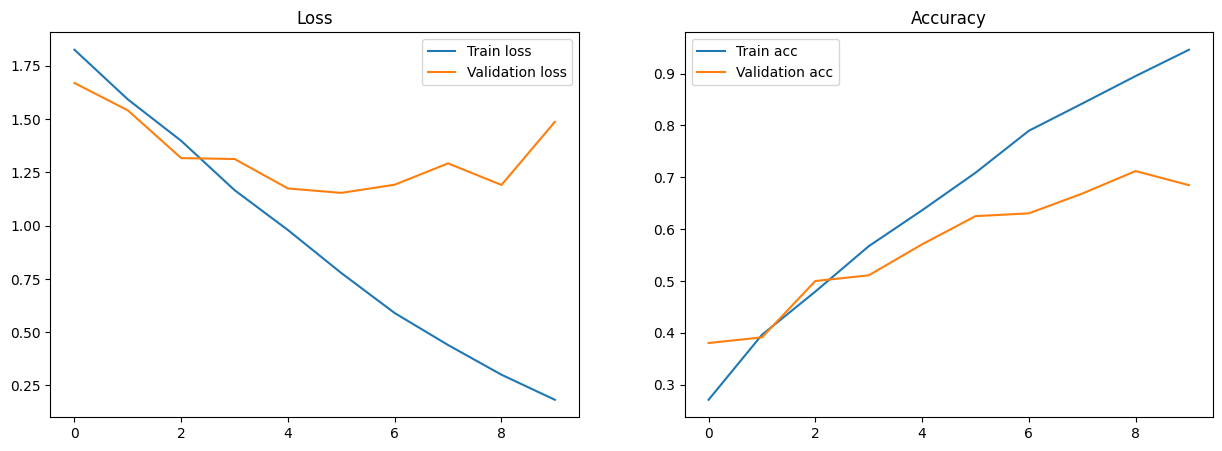

In [19]:
show_final_history(wav_history)

### 1.6.3 Generate Classification Report

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

y_pred = wav_model.predict(X_test_wav_reshaped)

y_test_categorical = np.argmax(y_test_wav_encoded, axis=1)
y_pred_categorical = np.argmax(y_pred, axis=1)

print("Classification Report On Waveform Model:")
print(classification_report(y_test_categorical, y_pred_categorical))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step
Classification Report On Waveform Model:
              precision    recall  f1-score   support

           0       0.56      0.28      0.37        18
           1       0.47      0.88      0.61        16
           2       0.46      0.63      0.53        27
           3       0.33      0.33      0.33        18
           4       0.60      0.30      0.40        30
           5       0.48      0.63      0.54        35
           6       0.67      0.62      0.64        29
           7       0.91      0.72      0.81        43

    accuracy                           0.56       216
   macro avg       0.56      0.55      0.53       216
weighted avg       0.60      0.56      0.56       216



# 2 Two Models to Train Each Batch : LMS Features

## 2.1 Load Split Data

### 2.1.1 Load Training Data

In [21]:
train_lms_dirs = [config.TRAIN_LMS_MFCCS, config.TRAIN_AUG_LMS_MFCCS]

X_train_lms = []
y_train_lms = []

for train_dir in train_lms_dirs:
    for file_name in os.listdir(train_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(train_dir, file_name)
            mfccs = np.load(file_path)
            #mfccs = scaler.fit_transform(mfccs)
            X_train_lms.append(mfccs)
            label = file_name.split('.npy')[0]
            y_train_lms.append(label)

X_train_lms = np.array(X_train_lms)
y_train_lms = np.array(y_train_lms)

In [22]:
X_train_lms.shape, y_train_lms.shape

((1685, 40, 775), (1685,))

### 2.1.2 Load Testing Data

In [23]:
test_dirs = [config.TEST_LMS_MFCCS]

X_test_lms = []
y_test_lms = []

for test_dir in test_dirs:
    for file_name in os.listdir(test_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(test_dir, file_name)
            mfccs = np.load(file_path)
            # add pcen
            #mfccs = librosa.pcen(mfccs, hop_length=512)
            #mfccs = scaler.fit_transform(mfccs)
            X_test_lms.append(mfccs)
            label = file_name.split('.npy')[0]
            y_test_lms.append(label)

X_test_lms = np.array(X_test_lms)
y_test_lms = np.array(y_test_lms)

In [24]:
X_test_lms.shape, y_test_lms.shape

((216, 40, 775), (216,))

### 2.1.3 Load Validation Data

In [25]:
val_dirs = [config.VAL_LMS_MFCCS]

X_val_lms = []
y_val_lms = []

for val_dir in val_dirs:
    for file_name in os.listdir(val_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(val_dir, file_name)
            mfccs = np.load(file_path)
            # add pcen
            #mfccs = librosa.pcen(mfccs, hop_length=512)
            #mfccs = scaler.fit_transform(mfccs)
            X_val_lms.append(mfccs)
            label = file_name.split('.npy')[0]
            y_val_lms.append(label)

X_val_lms = np.array(X_val_lms)
y_val_lms = np.array(y_val_lms)

In [26]:
X_val_lms.shape, y_val_lms.shape

((184, 40, 775), (184,))

## 2.2 Define Model

### 2.2.1 Reshape Data

In [27]:
X_train_lms_reshaped = X_train_lms.reshape(X_train_lms.shape[0], X_train_lms.shape[1], X_train_lms.shape[2], 1)
X_test_lms_reshaped = X_test_lms.reshape(X_test_lms.shape[0], X_test_lms.shape[1], X_test_lms.shape[2], 1)
X_val_lms_reshaped = X_val_lms.reshape(X_val_lms.shape[0], X_val_lms.shape[1], X_val_lms.shape[2], 1)

### 2.2.2 Model Definition

In [28]:
lms_model = models.Sequential([
    layers.Input(shape=X_train_lms_reshaped.shape[1:]),
    layers.Conv2D(64, (3, 3), activation='relu', name='conv_layer_1'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu', name='conv_layer_2'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', name='conv_layer_3'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


### 2.2.1 Show Summary of Model

In [29]:
lms_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_layer_1 (Conv2D)           │ (None, 38, 773, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 386, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 386, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 17, 384, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 192, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_3 (Conv2D)           │ (None, 6, 190, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 190, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 95, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,678,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,904,968 (72.12 MB)

 Trainable params: 18,904,712 (72.12 MB)

 Non-trainable params: 256 (1.00 KB)

In [30]:
lms_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
emotions = [label.split('-')[2] for label in y_train_lms]

label_encoder = LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions)
emotions_encoded = emotions_encoded.reshape(-1, 1)

encoder = OneHotEncoder(categories='auto', sparse_output=False) # try sparse true
y_train_lms_encoded = encoder.fit_transform(emotions_encoded)

y_test_lms_encoded = encoder.transform(label_encoder.transform([label.split('-')[2] for label in y_test_lms]).reshape(-1, 1))
y_val_lms_encoded = encoder.transform(label_encoder.transform([label.split('-')[2] for label in y_val_lms]).reshape(-1, 1))


## 2.3 Train Model

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

lms_history = lms_model.fit(X_train_lms_reshaped, y_train_lms_encoded,
                    epochs=10, 
                    batch_size=32,
                    validation_data=(X_val_lms_reshaped, y_val_lms_encoded),
                    callbacks=[callback]) 


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.1256 - loss: 11.0575 - val_accuracy: 0.0870 - val_loss: 2.1002
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.1297 - loss: 2.0821 - val_accuracy: 0.0870 - val_loss: 2.0786
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.1181 - loss: 2.0749 - val_accuracy: 0.0870 - val_loss: 2.0779
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.1647 - loss: 2.0710 - val_accuracy: 0.0870 - val_loss: 2.0775
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.1444 - loss: 2.0704 - val_accuracy: 0.1196 - val_loss: 2.0774
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.1490 - loss: 2.0702 - val_accuracy: 0.1196 - val_loss: 2.0846
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.1328 - loss: 2.0678 - val_accuracy: 0.1359 - val_loss: 2.0995
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.1370 - loss: 2.0685 - val_accuracy: 0.1359 - 

## 2.4 Evaluate Model

### 2.4.1 Assess Performance

In [33]:
test_loss, test_accuracy = lms_model.evaluate(X_test_lms_reshaped, y_test_lms_encoded)
print('Test accuracy:', test_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 603ms/step - accuracy: 0.1203 - loss: 2.0757
Test accuracy: 0.1527777761220932


### 2.4.2 Loss & Accuracy Graph

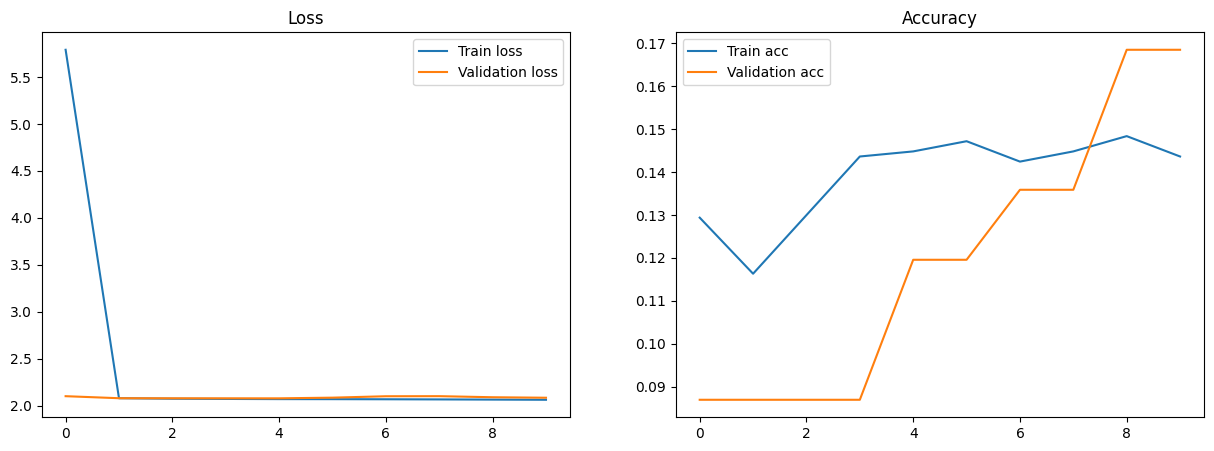

In [34]:
show_final_history(lms_history)

### 2.4.3 Generate Classification Report

In [35]:
y_pred = lms_model.predict(X_test_lms_reshaped)

y_test_categorical = np.argmax(y_test_lms_encoded, axis=1)
y_pred_categorical = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test_categorical, y_pred_categorical))


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        28
           4       0.15      1.00      0.27        33
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        30
           7       0.00      0.00      0.00        33

    accuracy                           0.15       216
   macro avg       0.02      0.12      0.03       216
weighted avg       0.02      0.15      0.04       216



c:\Users\Deirdre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deirdre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deirdre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

2.4.4 Confusion Matrix